In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =4

nref =1

p_refs = (/ 500 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 4 /) 

data wgt
     &     /0.65 , 0.65 , 0.75 , 0.95/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66/

klin =1e-24

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

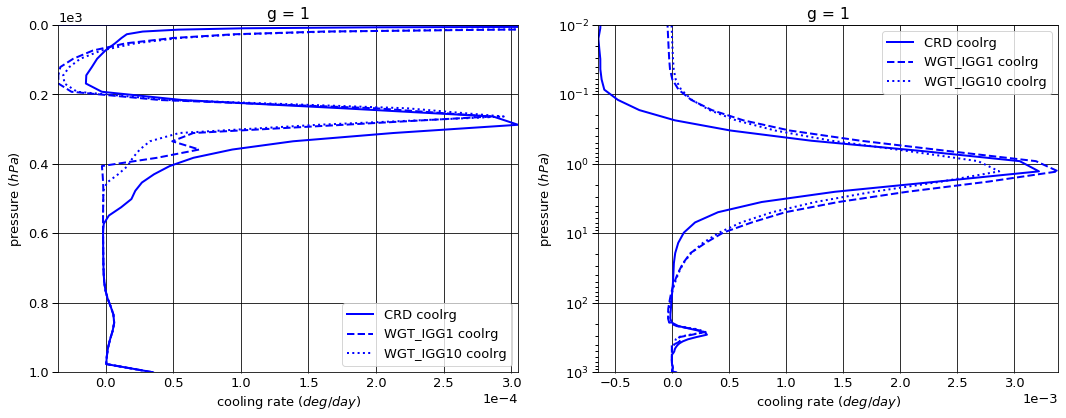

# Figure: cooling rate g-group 2

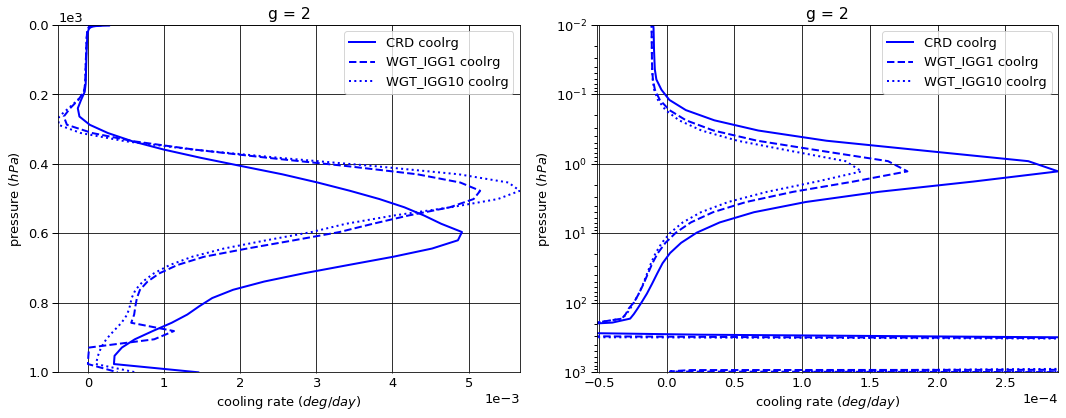

# Figure: cooling rate g-group 3

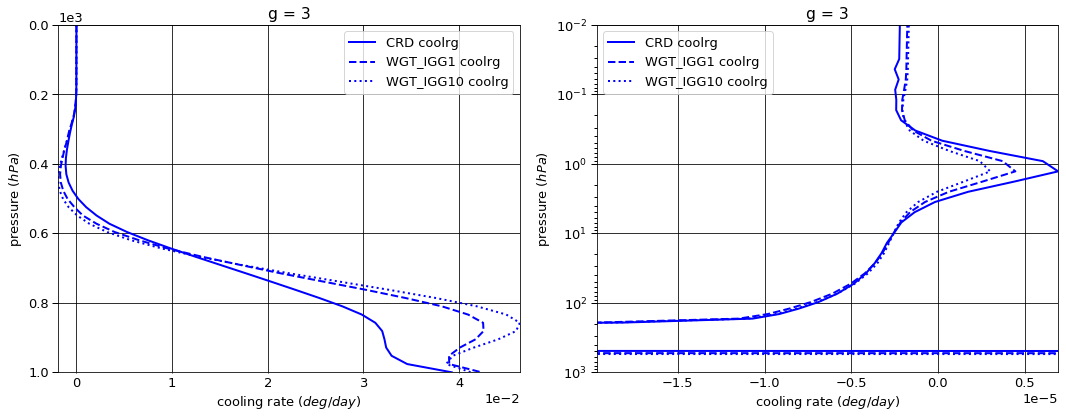

# Figure: cooling rate g-group 4

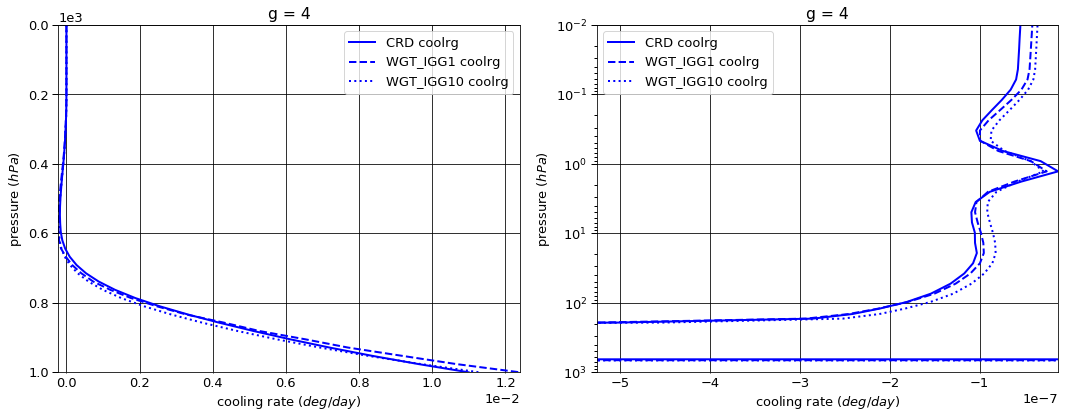

# Figure: cooling rate g-group total

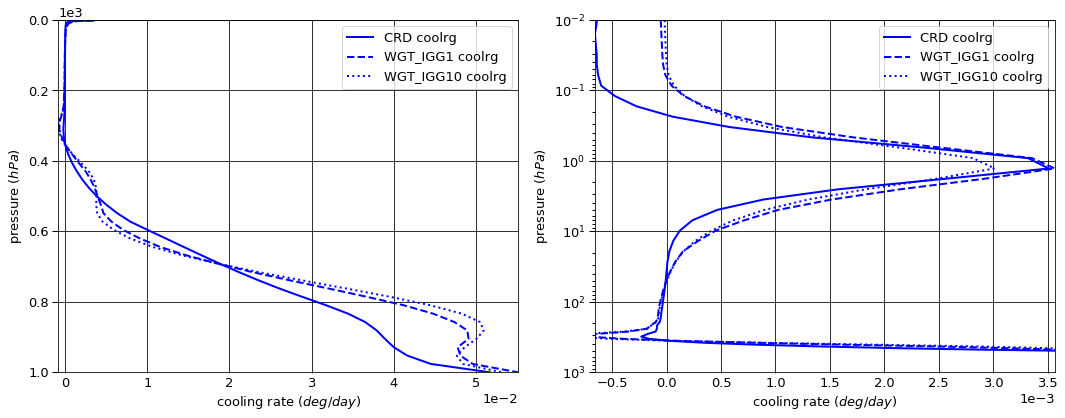

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.005350  0.000000 -0.005350
  1013.0   76    -0.068688  0.068590 -0.000098
2 0.0      1     -0.199296  0.000000 -0.199296
  1013.0   76    -0.765227  0.761149 -0.004078
3 0.0      1     -1.943613  0.000000 -1.943613
  1013.0   76    -2.781858  2.041869 -0.739989
4 0.0      1     -2.948881  0.000000 -2.948881
  1013.0   76    -3.009679  0.231892 -2.777787


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.004389  0.000000 -0.004389
  1013.0   76    -0.068688  0.068590 -0.000098
2 0.0      1     -0.161328  0.000000 -0.161328
  1013.0   76    -0.765227  0.764121 -0.001106
3 0.0      1     -1.807788  0.000000 -1.807788
  1013.0   76    -2.781858  2.433237 -0.348621
4 0.0      1     -2.943932  0.000000 -2.943932
  1013.0   76    -3.009679  0.245485 -2.764194


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.004184  0.000000 -0.004184
  1013.0   76    -0.068688  0.068590 -0.000098
2 0.0      1     -0.158648  0.000000 -0.158648
  1013.0   76    -0.765227  0.763597 -0.001630
3 0.0      1     -1.800516  0.000000 -1.800516
  1013.0   76    -2.781858  2.497036 -0.284822
4 0.0      1     -2.952754  0.000000 -2.952754
  1013.0   76    -3.009679  0.216738 -2.792941


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000960  0.000000  0.000960
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.037968  0.000000  0.037968
  1013.0   76     0.000000  0.002972  0.002972
3 0.0      1      0.135825  0.000000  0.135825
  1013.0   76     0.000000  0.391369  0.391369
4 0.0      1      0.004949  0.000000  0.004949
  1013.0   76     0.000000  0.013593  0.013593


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001166  0.000000  0.001166
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.040648  0.000000  0.040648
  1013.0   76     0.000000  0.002448  0.002448
3 0.0      1      0.143097  0.000000  0.143097
  1013.0   76     0.000000  0.455167  0.455167
4 0.0      1     -0.003874  0.000000 -0.003874
  1013.0   76     0.000000 -0.015154 -0.015154

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.647866e-04
  1001.112500 75     3.488246e-05
2 0.000312    1     -1.093341e-05
  1001.112500 75     1.450752e-03
3 0.000312    1     -2.104053e-06
  1001.112500 75     3.923483e-02
4 0.000312    1     -5.056032e-08
  1001.112500 75     1.099462e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -6.649948e-05
  1001.112500 75     3.488246e-05
2 0.000312    1     -1.157513e-05
  1001.112500 75     3.926084e-04
3 0.000312    1     -1.659947e-06
  1001.112500 75     4.234388e-02
4 0.000312    1     -3.640872e-08
  1001.112500 75     1.239454e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.840241e-05
  1001.112500 75     3.488246e-05
2 0.000312    1     -1.128141e-05
  1001.112500 75     6.264767e-04
3 0.000312    1     -1.573035e-06
  1001.112500 75     4.124332e-02
4 0.000312    1     -3.129324e-08
  1001.112500 75     1.128772e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      5.982871e-04
  1001.112500 75     0.000000e+00
2 0.000312    1     -6.417170e-07
  1001.112500 75    -1.058144e-03
3 0.000312    1      4.441065e-07
  1001.112500 75     3.109047e-03
4 0.000312    1      1.415161e-08
  1001.112500 75     1.399925e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      6.363842e-04
  1001.112500 75     0.000000e+00
2 0.000312    1     -3.479970e-07
  1001.112500 75    -8.242754e-04
3 0.000312    1      5.310185e-07
  1001.112500 75     2.008488e-03
4 0.000312    1      1.926708e-08
  1001.112500 75     2.930980e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.097139,0.0000,-5.097139
1013.0,76,-6.625452,3.1035,-3.521952



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.917437,0.000000,-4.917437
1013.0,76,-6.625452,3.511433,-3.114019



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.916102,0.000000,-4.916102
1013.0,76,-6.625452,3.545961,-3.079491



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.179702,0.000000,0.179702
1013.0,76,0.000000,0.407933,0.407933



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.181037,0.000000,0.181037
1013.0,76,0.000000,0.442461,0.442461


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000678
1001.112500,75,0.051715



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000080
1001.112500,75,0.055166



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000041
1001.112500,75,0.053192



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000598
1001.112500,75,0.003451



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000637
1001.112500,75,0.001477


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.003095,0.012248
2,0.041959,0.134222
3,0.290591,0.456726
4,0.664355,0.396805


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.649036e-21
2,6.818755e-23
3,1.000109e-24
4,6.466739e-29


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.649036e-21,NaN,0.003095,0.012248,0.003095,0.012248,500.0
2,6.818755e-23,0.014667,0.041959,0.134222,0.045055,0.146469,500.0
3,1.000109e-24,0.014667,0.290591,0.456726,0.335645,0.603195,500.0
4,6.466739e-29,0.000065,0.664355,0.396805,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog        ratio        taulyr
layer g pressure                                                          
1     1 0.000312     2.016313e-20  3.724362e-22    54.138474  1.127226e-06
      2 0.000312     7.150669e-23  1.387207e-24    51.547225  3.999582e-09
      3 0.000312     6.403018e-25  2.066128e-26    30.990419  4.133651e-11
      4 0.000312     5.981584e-27  4.800100e-30  1246.137300  4.839490e-13
2     1 0.000750     2.022107e-20  3.729637e-22    54.217265  4.553297e-07
      2 0.000750     7.179196e-23  1.390980e-24    51.612483  1.617384e-09
      3 0.000750     6.432511e-25  2.075678e-26    30.989929  1.672649e-11
      4 0.000750     6.027019e-27  4.920652e-30  1224.841600  1.964090e-13
3     1 0.001052     2.034424e-20  3.739822e-22    54.398959  6.424164e-07
      2 0.001052     7.240103e-23  1.398220e-24    51.780867  2.287363e-09
      3 0.001052     6.495556e-25  2.094535e-26    31.011923  2.368671e-11
      4 0.001052     6.124713e-27  5.029450e-30  1217.769900  2.799060e-13
4     1 0.001476     2.047497e-20  3.750825e-22    54.587904  9.070011e-07
      2 0.001476     7.305184e-23  1.406073e-24    51.954526  3.237656e-09
      3 0.001476     6.563157e-25  2.114870e-26    31.033385  3.357548e-11
      4 0.001476     6.230253e-27  5.171498e-30  1204.728900  3.994446e-13
5     1 0.002070     2.060615e-20  3.762174e-22    54.771935  1.280257e-06
      2 0.002070     7.370954e-23  1.414218e-24    52.120359  4.581829e-09
      3 0.002070     6.631732e-25  2.135772e-26    31.050751  4.758430e-11
      4 0.002070     6.338133e-27  5.357608e-30  1183.015400  5.699573e-13
6     1 0.002904     2.073768e-20  3.773986e-22    54.949012  1.807270e-06
      2 0.002904     7.437363e-23  1.422744e-24    52.274769  6.484813e-09
      3 0.002904     6.701247e-25  2.157403e-26    31.061645  6.744771e-11
      4 0.002904     6.448321e-27  5.605737e-30  1150.307300  8.134009e-13
7     1 0.004074     2.086955e-20  3.786431e-22    55.116673  2.551237e-06
      2 0.004074     7.504424e-23  1.431788e-24    52.412967  9.178501e-09
      3 0.004074     6.771737e-25  2.180009e-26    31.062887  9.560906e-11
      4 0.004074     6.560891e-27  5.939469e-30  1104.625700  1.160938e-12
8     1 0.005714     2.100176e-20  3.799752e-22    55.271401  3.601143e-06
      2 0.005714     7.572153e-23  1.441543e-24    52.528117  1.299041e-08
      3 0.005714     6.843246e-25  2.203945e-26    31.049987  1.355257e-10
      4 0.005714     6.675927e-27  6.391293e-30  1044.534700  1.656982e-12
9     1 0.008015     2.113436e-20  3.814294e-22    55.408314  5.083148e-06
      2 0.008015     7.640581e-23  1.452286e-24    52.610711  1.838621e-08
      3 0.008015     6.915840e-25  2.229714e-26    31.016717  1.921227e-10
      4 0.008015     6.793550e-27  7.005360e-30   969.764630  2.365234e-12
10    1 0.011243     2.126733e-20  3.830533e-22    55.520541  7.174822e-06
      2 0.011243     7.709722e-23  1.464404e-24    52.647497  2.602343e-08
      3 0.011243     6.989577e-25  2.258017e-26    30.954486  2.723686e-10
      4 0.011243     6.913862e-27  7.840258e-30   881.841060  3.376474e-12
11    1 0.015771     2.140066e-20  3.849137e-22    55.598579  1.012720e-05
      2 0.015771     7.779597e-23  1.478440e-24    52.620304  3.683454e-08
      3 0.015771     7.064536e-25  2.289846e-26    30.851571  3.861671e-10
      4 0.015771     7.036987e-27  8.971814e-30   784.343900  4.820619e-12
12    1 0.022122     2.153442e-20  3.871047e-22    55.629453  1.429423e-05
      2 0.022122     7.850276e-23  1.495161e-24    52.504568  5.213871e-08
      3 0.022122     7.140868e-25  2.326607e-26    30.692190  5.475632e-10
      4 0.022122     7.163163e-27  1.049482e-29   682.542470  6.883236e-12
13    1 0.031031     2.166874e-20  3.897573e-22    55.595471  2.017589e-05
      2 0.031031     7.921859e-23  1.515639e-24    52.267441  7.380594e-08
      3 0.031031     7.218783e-25  2.370281e-26    30.455395  7.765196e-10
      4 0.031031     7.292708e-27  1.252162e-29   5

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
